<a href="https://colab.research.google.com/github/SilvioCesarTeixeira/PJI4/blob/master/RNN_PJI4_UBS_VilaEde_QA_SRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalar Bibliotecas

In [ ]:
#!pip install openpyxl
!pip install pyexcel
!pip install sweetviz
!pip install seaborn

## Importar pacotes

In [ ]:
import pandas as pd
import numpy as np
import io
import openpyxl
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt

#from google.colab import files

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Código para upload de arquivo instalado no computador

In [ ]:
#uploaded = files.upload()

##Referenciar base de dados existente na rede

In [ ]:
url_SG = r'https://github.com/SilvioCesarTeixeira/PJI4/raw/master/SRAG_SubP_SP.xlsx'
url_QA = r'https://github.com/SilvioCesarTeixeira/PJI4/raw/master/Santana_SP_AQI.xlsx'

##Criar Dataframes

In [ ]:
df1 = pd.read_excel(url_QA, engine='openpyxl')
df2 = pd.read_excel(url_SG, engine='openpyxl')


Definir a linha zero do dataframe 1 como título das colunas

In [ ]:
df1.columns = df1.iloc[0]
df1 = df1.reindex(df1.index.drop(0))

Definindo a primeira coluna como data com padrão Português do Brasil

In [ ]:
df_QA = df1
df_QA['Data'] = pd.to_datetime(df1['date'], format='%Y/%m/%d').dt.strftime('%d/%m/%Y')
col_Data_Brasil = df_QA.iloc[:, -1]
df_QA = df_QA.iloc[:, 1:-1]
df_QA.insert(loc=0, column='Data', value=col_Data_Brasil)
df_QA

,Data,pm25,pm10,o3,no2,so2,co
1,08/03/2023,35,,24,,,
2,09/03/2023,47,,2,,,
3,10/03/2023,50,,18,,,
4,11/03/2023,52,,23,,,
5,12/03/2023,37,,14,,,
...,...,...,...,...,...,...,...
3267,24/11/2014,,,24,,,
3268,25/11/2014,,,28,,,
3269,01/01/2014,,,22,,,
3270,10/02/2019,,,,9,,


Remover linhas desnecessárias e renomear coluna do dataframe 2

In [ ]:
df_SRAG = df2
df_SRAG.columns = df_SRAG.iloc[2]
linhas_remover = list(range(0,3)) + list(range(1164,1168))
df_SRAG = df_SRAG.reindex(df_SRAG.index.drop(linhas_remover))
df_SRAG = df_SRAG.rename(columns={'Ano M�s Dia Notifica��o': 'Data'})
df_SRAG

2,Data,ARICANDUVA/FORMOSA/CARRAO,BUTANTA,CAMPO LIMPO,CAPELA DO SOCORRO,CASA VERDE/CACHOEIRINHA,CIDADE ADEMAR,CIDADE TIRADENTES,ERMELINO MATARAZZO,FREGUESIA/BRASILANDIA,...,SAO MATEUS,SAO MIGUEL,SAPOPEMBA,SE,VILA MARIA/VILA GUILHERME,VILA MARIANA,VILA PRUDENTE,N�o localizado,Localizado fora do MSP,Total
3,01/01/2020,-,1,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,2
4,02/01/2020,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,4
5,03/01/2020,-,-,2,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,3
6,05/01/2020,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,2
7,06/01/2020,-,1,1,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,12/03/2023,-,-,3,-,-,1,-,1,-,...,-,1,-,2,1,1,1,3,-,21
1160,13/03/2023,2,1,8,3,2,-,-,-,7,...,2,1,2,6,2,10,-,2,-,94
1161,14/03/2023,1,5,13,2,-,3,-,2,1,...,-,-,2,6,5,8,2,1,-,91
1162,15/03/2023,5,7,1,1,1,1,-,-,3,...,2,1,3,1,2,2,1,4,-,82


In [ ]:
df_SRAG.describe()

2,Data,ARICANDUVA/FORMOSA/CARRAO,BUTANTA,CAMPO LIMPO,CAPELA DO SOCORRO,CASA VERDE/CACHOEIRINHA,CIDADE ADEMAR,CIDADE TIRADENTES,ERMELINO MATARAZZO,FREGUESIA/BRASILANDIA,...,SAO MATEUS,SAO MIGUEL,SAPOPEMBA,SE,VILA MARIA/VILA GUILHERME,VILA MARIANA,VILA PRUDENTE,N�o localizado,Localizado fora do MSP,Total
count,1161,1161,1161,1161,1161,1161,1161,1161,1161,1161,...,1161,1161,1161,1161,1161,1161,1161,1161,1161,1161
unique,1161,37,41,56,58,36,43,22,25,42,...,45,42,36,54,41,41,33,43,6,541
top,01/01/2020,-,1,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1
freq,1,171,112,69,121,166,135,330,280,134,...,148,174,189,83,169,115,175,124,1065,11


##Juntar os dois dataframes, mas mantendo apenas as datas que coincidem

In [ ]:
df_SRAG = df_SRAG.loc[:, ['Data', 'VILA MARIA/VILA GUILHERME']]
df_base = pd.merge(df_QA, df_SRAG, how='inner', on='Data')

##Definir uma data de corte

In [ ]:
data_limite = '01/06/2021'
df_base['Data'] = pd.to_datetime(df_base['Data'], format='%d/%m/%Y')
df_base = df_base.loc[df_base['Data'] > data_limite]

Renomear colunas com titulo extenso e converter strings em tipos numericos

In [ ]:
df_base = df_base.rename(columns={' pm25':'PM25',' o3':'O3','VILA MARIA/VILA GUILHERME': 'VM_SRAG'})
df_base['PM25'] = pd.to_numeric(df_base['PM25'], errors='coerce')
df_base[' pm10'] = pd.to_numeric(df_base[' pm10'], errors='coerce')
df_base['O3'] = pd.to_numeric(df_base['O3'], errors='coerce')
df_base[' no2'] = pd.to_numeric(df_base[' no2'], errors='coerce')
df_base['VM_SRAG'] = pd.to_numeric(df_base['VM_SRAG'], errors='coerce')

In [ ]:
df_base.describe()

,PM25,pm10,O3,no2,VM_SRAG
count,696.000000,0.0,755.000000,0.0,658.000000
mean,52.252874,NaN,25.000000,NaN,6.721884
std,23.168246,NaN,11.020718,NaN,6.909736
min,5.000000,NaN,1.000000,NaN,1.000000
25%,36.000000,NaN,17.000000,NaN,2.000000
50%,49.000000,NaN,24.000000,NaN,4.000000
75%,64.000000,NaN,32.000000,NaN,9.000000
max,245.000000,NaN,73.000000,NaN,48.000000


Definir um dataframe base apenas com as colunas que contenham dados em quase todas as linhas

In [ ]:
df_base = df_base.loc[:, ['Data', 'PM25', 'O3','VM_SRAG']]

In [ ]:
df_base

,Data,PM25,O3,VM_SRAG
0,2023-03-08,35.0,24.0,3.0
1,2023-03-09,47.0,2.0,NaN
2,2023-03-10,50.0,18.0,NaN
3,2023-03-11,52.0,23.0,2.0
4,2023-03-12,37.0,14.0,1.0
...,...,...,...,...
1098,2021-06-21,NaN,13.0,17.0
1099,2021-06-29,NaN,11.0,11.0
1100,2021-02-22,NaN,30.0,15.0
1101,2021-03-01,NaN,26.0,20.0


##Utilizar o sweetviz para gerar um relatório com as estatísticas dos dados

In [ ]:
relatorio = sv.analyze(df_base, pairwise_analysis='off')
relatorio.show_html('Relatorio_VM_SRAG.html')

                                             |          | [  0%]   00:00 -> (? left)

Report Relatorio_VM_SRAG.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


##Preencher os valores NaN (não numéricos) com a média de cada variável

In [ ]:
df_base['PM25'].fillna(value=df_base['PM25'].mean(), inplace=True)
df_base['O3'].fillna(value=df_base['O3'].mean(), inplace=True)
df_base['VM_SRAG'].fillna(value=df_base['VM_SRAG'].mean(), inplace=True)

In [ ]:
# Substituir NaN pela mediana
#mediana = df['Atributo1'].median()
#df['Atributo1'].fillna(mediana, inplace=True)

# Substituir NaN pela moda
#moda = df['Atributo1'].mode()[0] # O método mode() retorna uma série, pegamos o primeiro elemento
#df['Atributo1'].fillna(moda, inplace=True)

In [ ]:
df_base.describe()

,PM25,O3,VM_SRAG
count,767.000000,767.000000,767.000000
mean,52.252874,25.000000,6.721884
std,22.068416,10.934053,6.399260
min,5.000000,1.000000,1.000000
25%,37.000000,17.000000,2.000000
50%,51.000000,24.000000,5.000000
75%,62.000000,31.000000,8.000000
max,245.000000,73.000000,48.000000


In [ ]:
df_base.info()

# definir função de normalização de logaritmo
#def normalizar_df_com_log(x):
    #return np.log(x) / np.max(np.log(x))

# aplicar a função de normalização as colunas PM25, O3 e VM_SRAG
#df_base['PM25'] = df_base['PM25'].apply(normalizar_df_com_log)
#df_base['O3'] = df_base['O3'].apply(normalizar_df_com_log)
#df_base['VM_SRAG'] = df_base['VM_SRAG'].apply(normalizar_df_com_log)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 767 entries, 0 to 1102
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Data     767 non-null    datetime64[ns]
 1   PM25     767 non-null    float64       
 2   O3       767 non-null    float64       
 3   VM_SRAG  767 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 30.0 KB


In [ ]:
df_corr = df_base
df_corr['Dias'] = (pd.to_datetime(df_corr['Data']) - pd.to_datetime('1900-01-01')).dt.days
df_corr = df_corr.drop(['Data'], axis = 1)
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 767 entries, 0 to 1102
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PM25     767 non-null    float64
 1   O3       767 non-null    float64
 2   VM_SRAG  767 non-null    float64
 3   Dias     767 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 30.0 KB


Gerar uma matriz de correlação entre as variáveis do dataframe base

In [ ]:
corr_matriz1 = df_corr.corr()

##Plotar o Mapa de Calor com as correlações calculadas

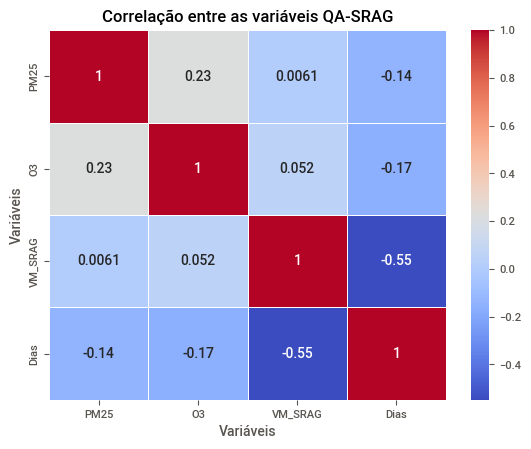

In [ ]:
sns.heatmap(corr_matriz1, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlação entre as variáveis QA-SRAG')
plt.xlabel('Variáveis')
plt.ylabel('Variáveis')
plt.show()

Plotar gráfico com dados do dataframe ao longo dos anos de 2020 a 2023.

In [ ]:
df_base['Data'] = pd.to_datetime(df_base['Data'], format='%d/%m/%Y')

In [ ]:
df_base = df_base.sort_values(['Data'], ascending=True)
print(df_base)
df_base.describe()

          Data  PM25    O3    VM_SRAG   Dias
625 2021-01-07  36.0  27.0   8.000000  44201
626 2021-01-08  23.0  25.0  10.000000  44202
627 2021-01-09  35.0  27.0  14.000000  44203
628 2021-01-10  54.0  26.0   6.000000  44204
629 2021-01-11  44.0  31.0  20.000000  44205
..         ...   ...   ...        ...    ...
4   2023-03-12  37.0  14.0   1.000000  44995
5   2023-03-13  31.0  13.0   2.000000  44996
6   2023-03-14  40.0  17.0   5.000000  44997
7   2023-03-15  51.0  21.0   2.000000  44998
8   2023-03-16  44.0  30.0   6.721884  44999

[767 rows x 5 columns]


,PM25,O3,VM_SRAG,Dias
count,767.000000,767.000000,767.000000,767.000000
mean,52.252874,25.000000,6.721884,44603.036506
std,22.068416,10.934053,6.399260,227.333392
min,5.000000,1.000000,1.000000,44201.000000
25%,37.000000,17.000000,2.000000,44411.500000
50%,51.000000,24.000000,5.000000,44606.000000
75%,62.000000,31.000000,8.000000,44798.500000
max,245.000000,73.000000,48.000000,44999.000000


Ajustando um dataframe ordenado por ano, com a soma de todos os casos por mês

In [ ]:
df_base_mmAAAA = df_base.groupby([df_base['Data'].dt.year, df_base['Data'].dt.month])['VM_SRAG'].sum()

In [ ]:
df_base_mmAAAA

Data  Data
2021  1       270.000000
      2       250.000000
      3       549.000000
      4       484.000000
      5       446.000000
      6       319.000000
      7       276.721884
      8       183.000000
      9       173.721884
      10      121.053191
      11      104.609422
      12      141.165653
2022  1       304.721884
      2       138.609422
      3       114.775076
      4       112.662614
      5        94.165653
      6       183.887538
      7       123.887538
      8        91.887538
      9       111.218845
      10      117.662614
      11      112.443769
      12       99.331307
2023  1       107.218845
      2        85.775076
      3        39.165653
Name: VM_SRAG, dtype: float64

##Plotando gráfico de internação por mês/ano

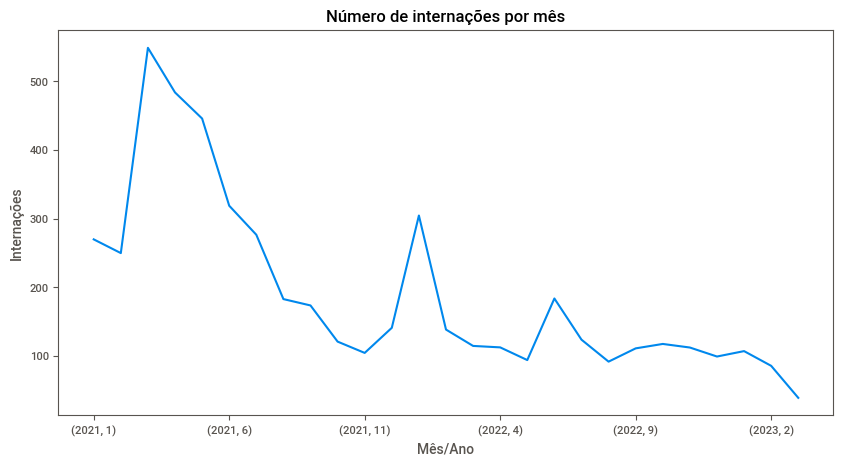

In [ ]:
df_base_mmAAAA.plot(kind='line', figsize=(10, 5))
plt.title('Número de internações por mês')
plt.xlabel('Mês/Ano')
plt.ylabel('Internações')
plt.show()

##Normalizar os dados aplicando uma transformação MinMax com intevalo de 0 até 1

In [ ]:
#Criar instância do MinMaxScaler
extremos_escala = (0,1)
normalizador = MinMaxScaler(feature_range = extremos_escala)

#Cria um dataframe apenas com dados numéricos
df_num = df_base.select_dtypes(include=['float64', 'int64'])

#Normaliza os dados do DataFrame com dados numéricos
df_norm = pd.DataFrame(normalizador.fit_transform(df_num), columns=df_num.columns)


In [ ]:
#df_norm = df_norm.drop(['Data'], axis = 1)
df_norm['PM25'].fillna(value=df_norm['PM25'].mean(), inplace=True)
df_norm['O3'].fillna(value=df_norm['O3'].mean(), inplace=True)
df_norm['VM_SRAG'].fillna(value=df_norm['VM_SRAG'].mean(), inplace=True)
df_norm['Dias'].fillna(value=df_norm['Dias'].mean(), inplace=True)
df_norm = df_norm.round(4)
df_norm

,PM25,O3,VM_SRAG,Dias
0,0.1292,0.3611,0.1489,0.0000
1,0.0750,0.3333,0.1915,0.0013
2,0.1250,0.3611,0.2766,0.0025
3,0.2042,0.3472,0.1064,0.0038
4,0.1625,0.4167,0.4043,0.0050
...,...,...,...,...
762,0.1333,0.1806,0.0000,0.9950
763,0.1083,0.1667,0.0213,0.9962
764,0.1458,0.2222,0.0851,0.9975
765,0.1917,0.2778,0.0213,0.9987


In [ ]:
#df_norm.iloc[1113:1127]

Eliminar linhas com valores nulos

In [ ]:
#df_norm = df_norm.reindex(df_norm.index.drop(1126))
#df_norm = df_norm.reindex(df_norm.index.drop(1114))

In [ ]:
#df_norm

Criar dataframe ordenado por data

In [ ]:
#df_norm_bydate = df_norm.sort_values(['Data'], ascending=True)


In [ ]:
#df_norm_bydate = df_norm_bydate.reset_index(drop=True)
#df_norm_bydate

Gerar Matriz de Correlação com dados normalizados

In [ ]:
#corr_matriz2 = df_norm_bydate.corr()

Gerar Heatmap com dados normalizados 

In [ ]:
#sns.heatmap(corr_matriz2, annot=True, cmap='coolwarm', linewidths=.5)
#plt.title('Correlação entre as variáveis QA-SRAG')
#plt.xlabel('Variáveis')
#plt.ylabel('Variáveis')
#plt.show()

In [ ]:
#sns.pairplot(df_norm_bydate)

##Separação Treino/Validação/Teste

O código seguinte cria um dataframe 1-c de todos os valores que constam na coluna VM_SRAG

##Criar um dataframe apenas com a coluna VM_SRAG, sem normalização

In [ ]:
# Utilizar dataframe
Y = df_norm.drop(['PM25','O3','Dias'], axis = 1)
Y


,VM_SRAG
0,0.1489
1,0.1915
2,0.2766
3,0.1064
4,0.4043
...,...
762,0.0000
763,0.0213
764,0.0851
765,0.0213


In [ ]:
# Utilizar Dataframe normalizado
#X = df_norm_bydate.drop(['Data','VM_SRAG'], axis=1)

# Utilizar Dataframe
X = df_norm.drop(['VM_SRAG'], axis=1)

X

,PM25,O3,Dias
0,0.1292,0.3611,0.0000
1,0.0750,0.3333,0.0013
2,0.1250,0.3611,0.0025
3,0.2042,0.3472,0.0038
4,0.1625,0.4167,0.0050
...,...,...,...
762,0.1333,0.1806,0.9950
763,0.1083,0.1667,0.9962
764,0.1458,0.2222,0.9975
765,0.1917,0.2778,0.9987


In [ ]:
# Separação desenvolvimento (90) e teste (10)
X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

# Separação treino (80) e validação (20)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.2, random_state=1)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(552, 3)
(138, 3)
(77, 3)
(552, 1)
(138, 1)
(77, 1)


Verificar a disponibilidade de CPU ou GPU para os tensores

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")    

cpu is available.


In [ ]:
x_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(Y_train.values)

x_val = torch.FloatTensor(X_val.values)
y_val = torch.FloatTensor(Y_val.values)

x_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(Y_test.values)

##Definir Modelo Preditivo (LSTM)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, 1)
        #self.linear = nn.Linear(hidden_size, dataset_size.shape[1])

    def forward(self, x):
        out, _ = self.lstm(x)
        #out = self.linear(out[-1])
        out = self.linear(out[-1].view(-1, hidden_size))
        return out

input_size = 3 # número de variáveis de entrada (PM25, O3, Dias)
hidden_size = 5 # número de unidades na camada oculta
num_layers = 2 # número de camadas de LSTM
lr = 0.0001 # taxa de aprendizagem
weight_decay=0.8 #taxa de penalidade L2
num_epochs = 200 # número de épocas de treinamento
batch_size = 15 # tamanho do lote


In [ ]:
#class LSTM(nn.Module):
#    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
#        super(LSTM, self).__init__()
#        self.hidden_dim = hidden_dim
#        self.num_layers = num_layers
#        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#        self.fc1 = nn.Linear(hidden_dim, output_dim)

#    def forward(self, x):
#        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
#        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

#        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

#        out = self.fc1(out[:, -1, :])
#        return out


##Instanciar Modelo, definir função de custo MSE e otimizador Adam

In [ ]:
# criar modelo
model = LSTM(input_size, hidden_size, num_layers)

# definir função de perda e otimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

##Treinar o modelo

In [ ]:
# treinar modelo
train_loss = []
valid_loss = []
for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        optimizer.zero_grad()
        batch_x = x_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        out = model(batch_x.unsqueeze(1))
        print (out)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        val_out = model(x_val.unsqueeze(1))
        val_loss = criterion(val_out, y_val)
        # Armazena os erros de treinamento e validação
        train_loss.append(loss)
        valid_loss.append(val_loss)
    print(f'Epoca {epoch}: Erro de Treinamento = {loss.item():.4f}, Erro de Validação = {val_loss.item():.4f}')
    
    

tensor([[-0.3027]], grad_fn=<AddmmBackward0>)
tensor([[-0.3006]], grad_fn=<AddmmBackward0>)
tensor([[-0.3020]], grad_fn=<AddmmBackward0>)
tensor([[-0.2996]], grad_fn=<AddmmBackward0>)
tensor([[-0.3002]], grad_fn=<AddmmBackward0>)
tensor([[-0.3013]], grad_fn=<AddmmBackward0>)
tensor([[-0.2981]], grad_fn=<AddmmBackward0>)
tensor([[-0.2985]], grad_fn=<AddmmBackward0>)
tensor([[-0.3010]], grad_fn=<AddmmBackward0>)
tensor([[-0.2996]], grad_fn=<AddmmBackward0>)
tensor([[-0.2992]], grad_fn=<AddmmBackward0>)
tensor([[-0.3009]], grad_fn=<AddmmBackward0>)
tensor([[-0.2991]], grad_fn=<AddmmBackward0>)
tensor([[-0.2975]], grad_fn=<AddmmBackward0>)
tensor([[-0.2993]], grad_fn=<AddmmBackward0>)
tensor([[-0.2984]], grad_fn=<AddmmBackward0>)
tensor([[-0.2979]], grad_fn=<AddmmBackward0>)
tensor([[-0.2969]], grad_fn=<AddmmBackward0>)
tensor([[-0.2981]], grad_fn=<AddmmBackward0>)
tensor([[-0.2976]], grad_fn=<AddmmBackward0>)
tensor([[-0.2974]], grad_fn=<AddmmBackward0>)
tensor([[-0.2969]], grad_fn=<Addmm

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([138, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(in

A saída de streaming foi truncada nas últimas 5000 linhas.
tensor([[-0.0266]], grad_fn=<AddmmBackward0>)
tensor([[-0.0265]], grad_fn=<AddmmBackward0>)
tensor([[-0.0265]], grad_fn=<AddmmBackward0>)
tensor([[-0.0266]], grad_fn=<AddmmBackward0>)
tensor([[-0.0265]], grad_fn=<AddmmBackward0>)
tensor([[-0.0263]], grad_fn=<AddmmBackward0>)
tensor([[-0.0264]], grad_fn=<AddmmBackward0>)
tensor([[-0.0262]], grad_fn=<AddmmBackward0>)
tensor([[-0.0262]], grad_fn=<AddmmBackward0>)
tensor([[-0.0262]], grad_fn=<AddmmBackward0>)
tensor([[-0.0260]], grad_fn=<AddmmBackward0>)
tensor([[-0.0259]], grad_fn=<AddmmBackward0>)
tensor([[-0.0260]], grad_fn=<AddmmBackward0>)
tensor([[-0.0259]], grad_fn=<AddmmBackward0>)
tensor([[-0.0258]], grad_fn=<AddmmBackward0>)
tensor([[-0.0258]], grad_fn=<AddmmBackward0>)
tensor([[-0.0258]], grad_fn=<AddmmBackward0>)
tensor([[-0.0256]], grad_fn=<AddmmBackward0>)
tensor([[-0.0257]], grad_fn=<AddmmBackward0>)
tensor([[-0.0255]], grad_fn=<AddmmBackward0>)
tensor([[-0.0254]], g

In [ ]:
test_set = x_test
#test_set = torch.tensor([[0.1625,	0.4028, 1.0000],[0.1625,	0.4028,	1.0000]])

In [ ]:
# Exemplo de iteração pelas linhas do tensor de entrada

import torch
# Inicializar lista para armazenar as saídas geradas
outputs = []

with torch.no_grad():
    # Iterar pelas linhas do tensor x_test
    for i in range(test_set.shape[0]):
        # Selecionar a i-ésima linha do tensor
        input_i = test_set[i:i+1, :]
        print (input_i)
        # Verificar se o tamanho do tensor de entrada é maior que zero
        if input_i.size(0) > 0:
            # Passar a i-ésima linha pela rede LSTM
            output_i = model(input_i.unsqueeze(1))
            print (output_i)
            # Adicionar a saída correspondente à i-ésima linha à lista
            outputs.append(output_i.squeeze().detach().numpy())
            print(outputs)

        # Passar a i-ésima linha pela rede LSTM
        #output_i = model(input_i)
        # Adicionar a saída correspondente à i-ésima linha à lista
        #outputs.append(output_i.squeeze().detach().numpy())

# Converter a lista de saídas para um tensor
#output_tensor = torch.tensor(outputs)

#print(f'Saídas geradas: {output_tensor}')


tensor([[0.1625, 0.2639, 0.3847]])
tensor([[0.0830]])
[array(0.08298926, dtype=float32)]
tensor([[0.1969, 0.1944, 0.1378]])
tensor([[0.0830]])
[array(0.08298926, dtype=float32), array(0.08298926, dtype=float32)]
tensor([[0.3417, 0.3472, 0.7569]])
tensor([[0.0830]])
[array(0.08298926, dtype=float32), array(0.08298926, dtype=float32), array(0.08298926, dtype=float32)]
tensor([[0.2500, 0.4306, 0.4687]])
tensor([[0.0830]])
[array(0.08298926, dtype=float32), array(0.08298926, dtype=float32), array(0.08298926, dtype=float32), array(0.08298926, dtype=float32)]
tensor([[0.1542, 0.3889, 0.8208]])
tensor([[0.0830]])
[array(0.08298926, dtype=float32), array(0.08298926, dtype=float32), array(0.08298926, dtype=float32), array(0.08298926, dtype=float32), array(0.08298926, dtype=float32)]
tensor([[0.1542, 0.2639, 0.6203]])
tensor([[0.0830]])
[array(0.08298926, dtype=float32), array(0.08298926, dtype=float32), array(0.08298926, dtype=float32), array(0.08298926, dtype=float32), array(0.08298926, dtype=

In [ ]:
# testar modelo
test_out = []
test_train = []
with torch.no_grad():
    test_out = model(x_test.unsqueeze(1))
    test_loss = criterion(test_out[:,0], y_test[:,0])
    test_train.append(test_loss) 
print(f'Erro de Teste = {test_loss.item():.4f}')
print(test_out[:,0])
print(y_test[:,0])
print(x_test)

##Verificar resultados de testes

In [ ]:
plot_y_test = y_test.numpy()
plot_y_pred = test_out.numpy()

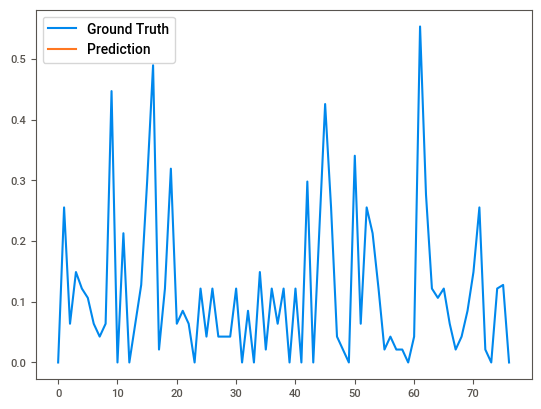

In [ ]:
plt.plot(plot_y_test, label='Ground Truth')
plt.plot(plot_y_pred, label='Prediction')
plt.legend()
plt.show()

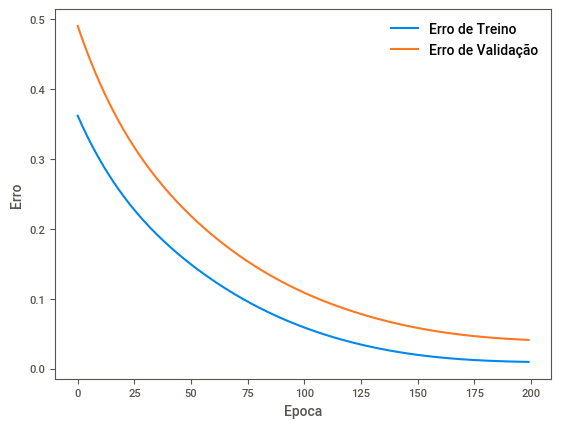

In [ ]:
# Plota as curvas de erro de treinamento e validação
plt.plot(torch.tensor(train_loss).detach().numpy(), label='Erro de Treino')
plt.plot(torch.tensor(valid_loss).detach().numpy(), label='Erro de Validação')
plt.legend(frameon=False)
plt.xlabel('Epoca')
plt.ylabel('Erro')
plt.show()

In [ ]:
predictions_train = []
predictions_val = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(x_train)
    predictions_val = model(x_val)
    predictions_test = model(x_test)

# Cálculo do erro (Função de Custo)
erro_train = criterion(predictions_train,y_train)
erro_val = criterion(predictions_val,y_val)
erro_test = criterion(predictions_test,y_test)

print(predictions_train)
print(predictions_val)
print(predictions_test)
print(f"Erro de Treino: {erro_train}")
print(f"Erro de Validação: {erro_val}")
print(f"Erro de Teste: {erro_test}")

tensor([0.0950])
tensor([0.0950])
tensor([0.0950])
Erro de Treino: 0.015407254919409752
Erro de Validação: 0.03666044771671295
Erro de Teste: 0.015361095778644085


In [ ]:
# Cálculo da Acurácia de Classificação:

pred_train = torch.argmax(predictions_train, dim=1)
label_train = torch.argmax(y_train, dim=1)
pred_val = torch.argmax(predictions_val, dim=1)
label_val = torch.argmax(y_val, dim=1)
pred_test = torch.argmax(predictions_test, dim=1)
label_test = torch.argmax(y_test, dim=1)

In [ ]:
acc_train = accuracy_score(label_train, pred_train)
acc_val = accuracy_score(label_val, pred_val)
acc_test = accuracy_score(label_test, pred_test)


print(f"Acurácia de Treino: {acc_train*100:.2f}%")
print(f"Acurácia de Validação: {acc_val*100:.2f}%")
print(f"Acurácia de Teste: {acc_test*100:.2f}%")

TypeError: ignored

# Salvar o modelo Treinado

In [ ]:
torch.save(model, 'modelo_LSTM_treinado.pt')

In [ ]:
df_base.describe()

,PM25,O3,VM_SRAG,Dias
count,767.000000,767.000000,767.000000,767.000000
mean,52.252874,25.000000,6.721884,44603.036506
std,22.068416,10.934053,6.399260,227.333392
min,5.000000,1.000000,1.000000,44201.000000
25%,37.000000,17.000000,2.000000,44411.500000
50%,51.000000,24.000000,5.000000,44606.000000
75%,62.000000,31.000000,8.000000,44798.500000
max,245.000000,73.000000,48.000000,44999.000000


In [ ]:
#saída do modelo
min = 1 #valor mínimo de VM_SRAG no dataset df_base
max = 48 #valor máximo de VM_SRAG no dataset df_base
VM_SRAG_pred = model(entradas) # entradas são os parâmetros normalizados de PM25, O3 e Dias, como tensor Pytorch
# num inter é o número de internações previstas para os parâmetros 'entradas'
num_inter = VM_SRAG_pred * (max - min) + min